In [1]:
import random
import time
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Start Spark
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

json_output_path = "../../output/100M_bigann_base.json"
df = spark.read.json(json_output_path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/06 21:10:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
# ----- Configuration Variables -----

sample_size = 10000  # Number of samples to extract from the JSON file
K = 100  # Number of clusters for clustering algorithm
max_iterations = 10 # Max number of iterations when running K-means

# Distance metric for calculations
distance_metric = 2

# Available distance metrics:
# 1  -> Manhattan distance
# 2  -> Euclidean distance
# np.inf -> Chebyshev distance

In [12]:
# Get sample_size of rows
df_sample = df.limit(sample_size)

In [13]:
# Load the data
data_rdd = df_sample.select("vector").rdd.map(lambda row: row[0])

In [14]:

# Initialise K centroides randomly
centroids = data_rdd.takeSample(False, K)

print("Centroïdes initiated:", centroids)

Centroïdes initiated: [[-126, -110, -99, -120, -127, -126, -127, -128, -19, -81, -122, -127, -128, -126, -122, -100, -92, -124, -122, -119, -115, -60, -66, -102, -128, -120, -94, -107, -91, -33, -110, -128, -110, -37, -73, -126, -127, -127, -127, -127, -1, -66, -114, -127, -128, -126, -125, -45, -67, -106, -105, -120, -82, -71, -111, -83, -128, -128, -127, -76, -8, -50, -126, -128, -91, -26, -115, -127, -128, -124, -123, -128, -1, -1, -68, -128, -128, -127, -128, -123, -115, -2, -1, -98, -107, -116, -126, -125, -128, -120, -64, -1, -41, -126, -128, -128, -107, -112, -128, -128, -113, -105, -121, -127, -1, -74, -122, -128, -128, -122, -118, -117, -109, -107, -79, -123, -126, -67, -86, -121, -128, -125, -92, -78, -114, -76, -123, -128], [-128, -128, -110, -62, -92, -113, -70, -123, -124, -128, -111, -94, -117, -104, -21, -113, -117, -128, -128, -125, -118, -88, -15, -73, -90, -127, -127, -127, -104, -62, -100, -60, -122, -128, -125, -105, -101, -119, -84, -103, -78, -114, -124, -70, -49,

In [15]:
def closest_centroid(point, centroids):
    """Returns the index of the nearest centroid."""
    distances = [np.linalg.norm(np.array(point) - np.array(c), ord=distance_metric) for c in centroids]
    return np.argmin(distances), point

In [16]:
def compute_new_centroids(clustered_rdd, K):
    """Computes the new centroids by averaging the points assigned to each cluster."""
    cluster_groups = clustered_rdd.map(lambda x: (x[0], (np.array(x[1]), 1)))  # (cluster, (point, 1))
    
    # Sum of points and count of elements per cluster
    cluster_sums = cluster_groups.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))
    
    # Average of points (new centroids)
    new_centroids = cluster_sums.map(lambda x: x[1][0] / x[1][1]).collect()
    
    return new_centroids

In [17]:
loss_values = []  # Store the loss at each iteration

total_start_time = time.time()  # Start overall timer

for i in range(max_iterations):
    iteration_start_time = time.time()  # Start iteration timer
    
    clustered_rdd = data_rdd.map(lambda point: closest_centroid(point, centroids))
    
    loss = clustered_rdd.map(lambda x: np.linalg.norm(np.array(x[1]) - np.array(centroids[x[0]]), ord=distance_metric) ** 2).sum()
    loss_values.append(loss)
    
    centroids = compute_new_centroids(clustered_rdd, K)
    
    iteration_time = time.time() - iteration_start_time  # Execution time for the iteration
    
    print(f"Iteration {i+1}: Loss = {loss:.4f}, Time = {iteration_time:.2f}s")

total_time = time.time() - total_start_time  # Compute total execution time

print(f"K-Means Completed! Total Time: {total_time:.2f}s")

Iteration 1: Loss = 1310723906.0000, Time = 15.32s


Iteration 2: Loss = 866211122.4785, Time = 9.68s


Iteration 3: Loss = 839032019.4987, Time = 9.49s


Iteration 4: Loss = 827569923.9619, Time = 9.48s


Iteration 5: Loss = 821612180.6809, Time = 9.68s


Iteration 6: Loss = 817903782.5423, Time = 9.46s


Iteration 7: Loss = 815312849.2934, Time = 9.47s


Iteration 8: Loss = 813445188.9710, Time = 9.62s


Iteration 9: Loss = 811895550.9196, Time = 9.52s


Iteration 10: Loss = 810823730.7740, Time = 9.51s
K-Means Completed! Total Time: 101.25s


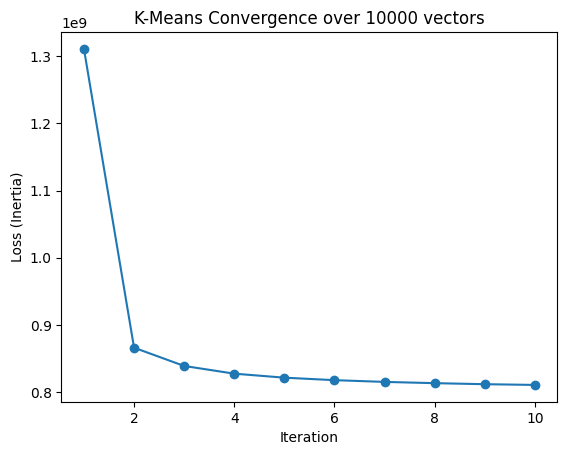

In [18]:
plt.plot(range(1, max_iterations + 1), loss_values, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Loss (Inertia)")
plt.title("K-Means Convergence over " + str(sample_size) + " vectors")
plt.show()